In [ ]:
# import data science and visualization libraries
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import boto3
import sagemaker
import json
import joblib
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner
)
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# Setting SageMaker variables
sess = sagemaker.Session()
write_bucket='itam-analytics-proyectofinal-zaret-daan'
write_prefix = "forestcover/output"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)

sagemaker_role = sagemaker.get_execution_role()
sagemaker_client = boto3.client("sagemaker")
read_bucket = "itam-analytics-proyectofinal-zaret-daan"
read_prefix = "forestcover"

train_data_key = f"{read_prefix}/train.csv"
test_data_key = f"{read_prefix}/test.csv"
validation_data_key = f"{read_prefix}/validation.csv"

batch_data_key = f"{read_prefix}/batch.csv"

In [4]:
# download the raw data to the notebook
s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-sample-files", "datasets/tabular/uci_covtype/covtype.data.gz", "covtype.data.gz"
)

In [5]:
# unzip the raw dataset
!gunzip covtype.data.gz

In [6]:
BUCKET_NAME = write_bucket
s3.create_bucket(Bucket=BUCKET_NAME)

{'ResponseMetadata': {'RequestId': 'N2KTNFWJNEAT9Y19',
  'HostId': 'BKtPQ7BzRy1zTUYl9Gd8f2aOMZ/aQM0ClEObvGiIjtzqmnevNsOFtNufN66pvaMMjvUzcVrqZG4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'BKtPQ7BzRy1zTUYl9Gd8f2aOMZ/aQM0ClEObvGiIjtzqmnevNsOFtNufN66pvaMMjvUzcVrqZG4=',
   'x-amz-request-id': 'N2KTNFWJNEAT9Y19',
   'date': 'Fri, 19 May 2023 17:33:34 GMT',
   'location': '/itam-analytics-proyectofinal-zaret-daan',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/itam-analytics-proyectofinal-zaret-daan'}

In [7]:
!aws --region {region} s3 cp covtype.data s3://itam-analytics-proyectofinal-zaret-daan/raw-dataset/covtype.data

upload: ./covtype.data to s3://itam-analytics-proyectofinal-zaret-daan/raw-dataset/covtype.data


<class 'numpy.ndarray'>
(581011, 55)


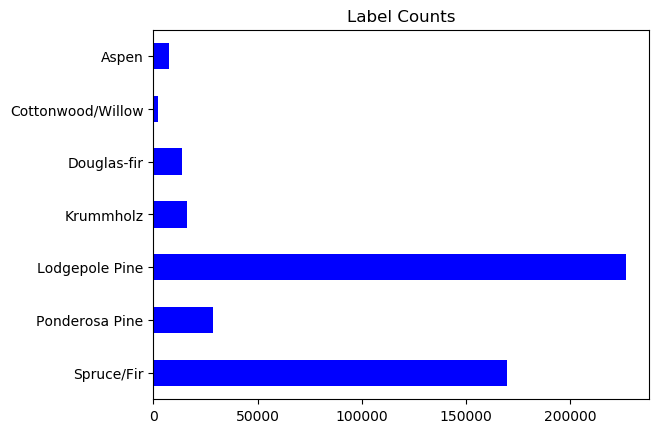

In [28]:
#read the csv and extract features and labels
covtype = pd.read_csv("covtype.data", delimiter=",", dtype="float32").values
covtype_features, covtype_labels = covtype[:, :54], covtype[:, 54]

print(type(covtype))

# transform labels to 0 index
covtype_labels -= 1

print(covtype.shape)

# shuffle and split into train and test sets
np.random.seed(0)
train_features, test_features, train_labels, test_labels = train_test_split(
    covtype_features, covtype_labels, test_size=0.2
)
# further split the test set into validation and test sets
val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5
)

# assign label names and count label frequencies
label_map = {
    0: "Spruce/Fir",
    1: "Lodgepole Pine",
    2: "Ponderosa Pine",
    3: "Cottonwood/Willow",
    4: "Aspen",
    5: "Douglas-fir",
    6: "Krummholz",
}

label_counts = (
    pd.DataFrame(data=train_labels)[0]
    .map(label_map)
    .value_counts(sort=False)
    .sort_index(ascending=False)
)

label_counts.plot(kind="barh", color="blue", title="Label Counts")

In [29]:
print(train_features.shape)
print(train_labels.shape)
print(val_features.shape)
print(val_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(464808, 54)
(464808,)
(58101, 54)
(58101,)
(58102, 54)
(58102,)


In [48]:
from numpy import savetxt
np.savetxt("train_features.data", train_features, delimiter=",")
np.savetxt("train_labels.data", train_features, delimiter=",")
np.savetxt("val_features.data", train_features, delimiter=",")
np.savetxt("val_labels.data", train_features, delimiter=",")
np.savetxt("test_features.data", train_features, delimiter=",")
np.savetxt("test_labels.data", train_features, delimiter=",")

In [49]:
!aws --region {region} s3 cp train_features.data s3://itam-analytics-proyectofinal-zaret-daan/train/train_features.data
!aws --region {region} s3 cp train_labels.data s3://itam-analytics-proyectofinal-zaret-daan/train/train_labels.data

upload: ./train_features.data to s3://itam-analytics-proyectofinal-zaret-daan/train/train_features.data
upload: ./train_labels.data to s3://itam-analytics-proyectofinal-zaret-daan/train/train_labels.data


In [50]:
!aws --region {region} s3 cp val_features.data s3://itam-analytics-proyectofinal-zaret-daan/val/val_features.data
!aws --region {region} s3 cp val_labels.data s3://itam-analytics-proyectofinal-zaret-daan/val/val_labels.data!aws --region {region} s3 cp train_features.data s3://itam-analytics-proyectofinal-zaret-daan/train/train_features.data
!aws --region {region} s3 cp test_features.data s3://itam-analytics-proyectofinal-zaret-daan/test/test_features.data
!aws --region {region} s3 cp test_labels.data s3://itam-analytics-proyectofinal-zaret-daan/test/test_labels.data

upload: ./val_features.data to s3://itam-analytics-proyectofinal-zaret-daan/val/val_features.data

Unknown options: s3,cp,train_features.data,s3://itam-analytics-proyectofinal-zaret-daan/train/train_features.data
upload: ./test_features.data to s3://itam-analytics-proyectofinal-zaret-daan/test/test_features.data
upload: ./test_labels.data to s3://itam-analytics-proyectofinal-zaret-daan/test/test_labels.data


In [55]:
write_prefix

'forestcover/output'

In [56]:
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

estimator_output_uri = f"s3://{write_bucket}/training_jobs"

# instantiate the LinearLearner estimator object
multiclass_estimator = sagemaker.LinearLearner(
    role=sagemaker.get_execution_role(),
    output_path=estimator_output_uri,
    code_location=estimator_output_uri,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    predictor_type="multiclass_classifier",
    num_classes=7,
)

In [57]:
# wrap data in RecordSet objects
train_records = multiclass_estimator.record_set(train_features, train_labels, channel="train")
val_records = multiclass_estimator.record_set(val_features, val_labels, channel="validation")
test_records = multiclass_estimator.record_set(test_features, test_labels, channel="test")

In [ ]:
import time
from sagemaker.tuner import IntegerParameter, ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

job_name = "forestcover-hyperparameter-tuning-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Tuning job name:", job_name)

# Linear Learner tunable hyper parameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html
hyperparameter_ranges = {
    "wd": ContinuousParameter(1e-7, 1, scaling_type="Auto"),
    "learning_rate": ContinuousParameter(1e-5, 1, scaling_type="Auto"),
    "mini_batch_size": IntegerParameter(100, 2000, scaling_type="Auto"),
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 6
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 2


hp_tuner = HyperparameterTuner(
    linear,
    "validation:binary_f_beta",
    hyperparameter_ranges,
    max_jobs=max_jobs,
    max_parallel_jobs=max_parallel_jobs,
    objective_type="Maximize",
)


# Launch a SageMaker Tuning job to search for the best hyperparameters
hp_tuner.fit(inputs={"train": s3_train_data, "validation": s3_validation_data}, job_name=job_name)

In [58]:
# start a training job
multiclass_estimator.fit([train_records, val_records, test_records])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-05-19-22-13-41-862


2023-05-19 22:13:42 Starting - Starting the training job...
2023-05-19 22:14:17 Starting - Preparing the instances for training.........
2023-05-19 22:15:35 Downloading - Downloading input data...
2023-05-19 22:16:05 Training - Downloading the training image......
2023-05-19 22:17:21 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/19/2023 22:17:37 INFO 140641673197376] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

In [67]:
# deploy a model hosting endpoint
multiclass_predictor = multiclass_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge"
)

# split the test dataset into 100 batches and evaluate using prediction endpoint
prediction_batches = [multiclass_predictor.predict(batch) for batch in np.array_split(test_features, 100)]

# parse protobuf responses to extract predicted labels
extract_label = lambda x: x.label["predicted_label"].float32_tensor.values
test_preds = np.concatenate(
    [np.array([extract_label(x) for x in batch]) for batch in prediction_batches]
)
test_preds = test_preds.reshape((-1,))
test_preds

array([1., 0., 1., ..., 0., 1., 1.])

In [61]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label["predicted_label"].float32_tensor.values
    test_preds = np.concatenate(
        [np.array([extract_label(x) for x in batch]) for batch in prediction_batches]
    )
    test_preds = test_preds.reshape((-1,))

    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]

    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(
            test_preds == target_label, test_labels == target_label
        ).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({"recall": recall_per_class, "class_label": classes})
    recall.sort_values("class_label", ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(
        label_mapper(test_labels),
        label_mapper(test_preds),
        rownames=["Actuals"],
        colnames=["Predictions"],
        normalize="index",
    )

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="YlGnBu").set_title(
        "Confusion Matrix"
    )
    ax = recall.plot(
        kind="barh", x="class_label", y="recall", color="steelblue", title="Recall", legend=False
    )
    ax.set_ylabel("")
    print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.720


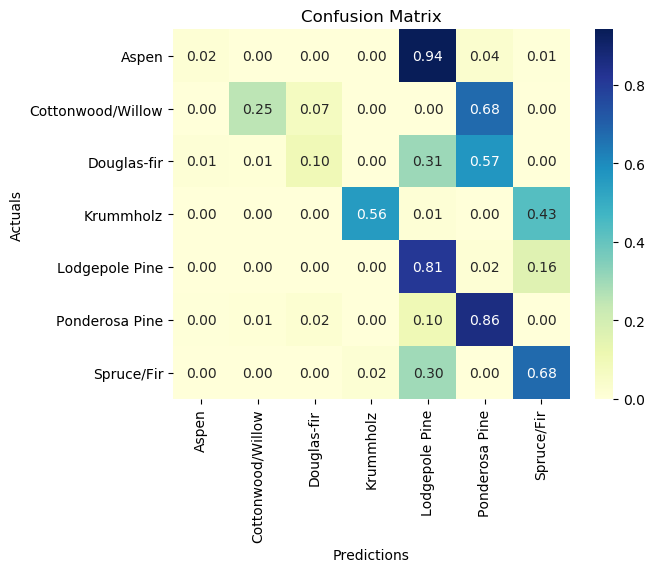

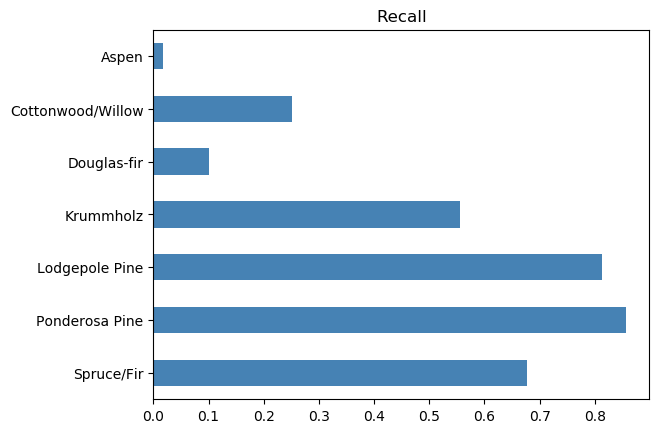

In [64]:
# evaluate metrics of the model trained with default hyperparameters
evaluate_metrics(multiclass_predictor, test_features, test_labels)

In [88]:
# delete endpoints
multiclass_predictor.delete_endpoint()
#balanced_multiclass_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-05-20-00-45-20-521
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-05-20-00-45-20-521
